# Create maps showing average demographic characteristic (e.g. IMD score) for each IVT unit catchment

Using shapefile from from `02_combine_demographic_data.ipynb`, create maps of with the weighted population average for each IVT unit of:
* IMD score
* Income domain score

Notes:
* When using the 2018 age CSV file, there were two Welsh hospital catchments (CF311RQ Bridgend, CF144XW Cardiff) that each contained two LSOAs that are not present in that age file (Rhondda Cynon Taf 023F, Rhondda Cynon Taf 027F, Rhondda Cynon Taf 027G, Rhondda Cynon Taf 023G). Since we use the population count from this age csv file to calculate a weighted sum for the IVT catchment, these LSOAs were previously (1) excluded from the weighted mean, and (2) excluded from the map. However, in the 2020 age CSV file now used, these areas have data, so **these steps are no longer required and have been removed**.
* To help with geopandas use https://github.com/MichaelAllen1966/2010_geopandas/blob/main/geopandas_1.ipynb
* Uses MatPlotLib for mapping the data since that gives us more power than the GeoPandas DataFrame plot method.

## Import libraries and define file paths

In [1]:
from dataclasses import dataclass
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import os
import pandas as pd

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data'
    countries = 'Countries_(December_2022)_GB_BFC.zip'
    collated = 'collated_data.csv'
    ivt_catchment = 'ivt_catchment.shp'
    hospitals = 'stroke_hospitals_2022.csv'


paths = Paths()

## Load country outline

In [3]:
# Load country outline
outline = gpd.read_file(os.path.join(paths.data, paths.countries))

# Drop Scotland
mask = outline['CTRY22NM'] != 'Scotland'
outline = outline[mask]

# Convert to epsg:3857
outline = outline.to_crs(epsg=3857)

## Find weighted average income domain score by closest IVT unit

Read in collated_data.csv which has information by LSOA.

In [4]:
df_lsoa = pd.read_csv(os.path.join(paths.data, paths.collated))
df_lsoa.head(2)

,LSOA,admissions,closest_ivt_unit,closest_ivt_unit_time,closest_mt_unit,closest_mt_unit_time,closest_mt_transfer,closest_mt_transfer_time,total_mt_time,ivt_rate,...,age_band_males_45,age_band_males_50,age_band_males_55,age_band_males_60,age_band_males_65,age_band_males_70,age_band_males_75,age_band_males_80,age_band_males_85,age_band_males_90
0,Welwyn Hatfield 010F,0.666667,SG14AB,18.7,NW12BU,36.9,CB20QQ,39.1,57.8,6.8,...,47,66,59,28,33,28,26,14,5,3
1,Welwyn Hatfield 012A,4.000000,SG14AB,19.8,NW12BU,36.9,CB20QQ,39.1,58.9,6.8,...,62,60,80,53,24,18,21,12,5,4


Group data by closest IVT unit and calculate the weighted average of income domain score - [see stackoverflow tutorial here](https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe).

In [5]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=df_lsoa.loc[x.index, 'population_all'])

# Groupby closest IVT unit and find total population and weighted average
df_ivt_ids = (
    df_lsoa
    .groupby(['closest_ivt_unit'])
    .agg(all_persons=('population_all', 'sum'),
         income_domain_score_weighted_mean=('income_domain_score', wm)))

df_ivt_ids

,all_persons,income_domain_score_weighted_mean
closest_ivt_unit,,
B152TH,963012,0.182951
B714HJ,1012389,0.202612
BA13NG,483031,0.083469
BA214AT,274432,0.095511
BB23HH,486120,0.177377
...,...,...
WD180HB,592250,0.080071
WF14DG,590899,0.148666
WR51DD,412669,0.093969


The range of people across the 113 catchments is: 87086 to 1479138
Median number of people: 483031.0


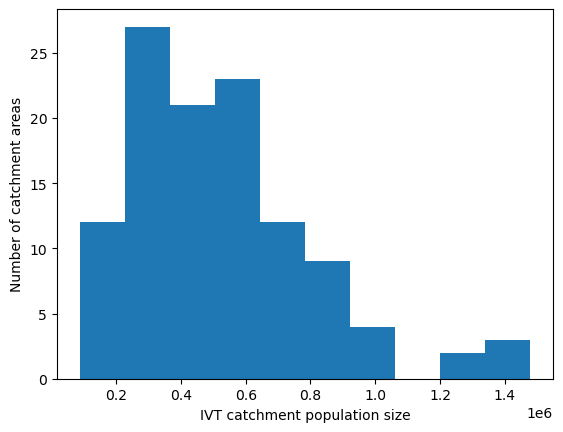

In [6]:
# Print the range in population size of each catchment area
print(f"The range of people across the {df_ivt_ids.shape[0]} catchments is: " +
      f"{round(df_ivt_ids['all_persons'].min(),1)} to " +
      f"{round(df_ivt_ids['all_persons'].max(),1)}")

# Print the median population size
print(f"Median number of people: {round(df_ivt_ids['all_persons'].median(),2)}")

# Create histogram to show distribution in population size of catchment areas
plt.hist(df_ivt_ids['all_persons'])
plt.xlabel('IVT catchment population size')
plt.ylabel('Number of catchment areas')
plt.show()

## Load IVT catchment shapefile

Load the shape file of the catchments for the IVT units in England and Wales into a GeoPandas DataFrame. Note that we can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. EPSG:27700 is the crs to use when geography is in BNG (British National Grid Eastings and Northings).

Note: If this fails to run, you need to run `02_create_ivt_catchment_shapefile.ipynb` to generate the IVT catchment shapefile.

In [7]:
# Load IVT catchment shapefile
gdf_ivt_catchment = gpd.read_file(
    os.path.join(paths.data, paths.ivt_catchment), crs='EPSG:27700')

# Set index
gdf_ivt_catchment.set_index(['closest_iv'], inplace=True)

# Preview the dataframe
gdf_ivt_catchment.head()

,LSOA11NM,LSOA11CD,LSOA11NMW,geometry
closest_iv,,,,
B152TH,Birmingham 067A,E01008881,Birmingham 067A,"MULTIPOLYGON (((403011.723 266679.152, 402597...."
B714HJ,Birmingham 037A,E01008899,Birmingham 037A,"MULTIPOLYGON (((395950.714 272162.470, 395950...."
BA13NG,Bath and North East Somerset 007A,E01014370,Bath and North East Somerset 007A,"POLYGON ((354665.594 144552.500, 354665.594 14..."
BA214AT,East Devon 005A,E01019886,East Devon 005A,"MULTIPOLYGON (((330365.588 98427.209, 330281.9..."
BB23HH,Bolton 001B,E01004803,Bolton 001B,"POLYGON ((369965.000 416593.000, 370071.000 41..."


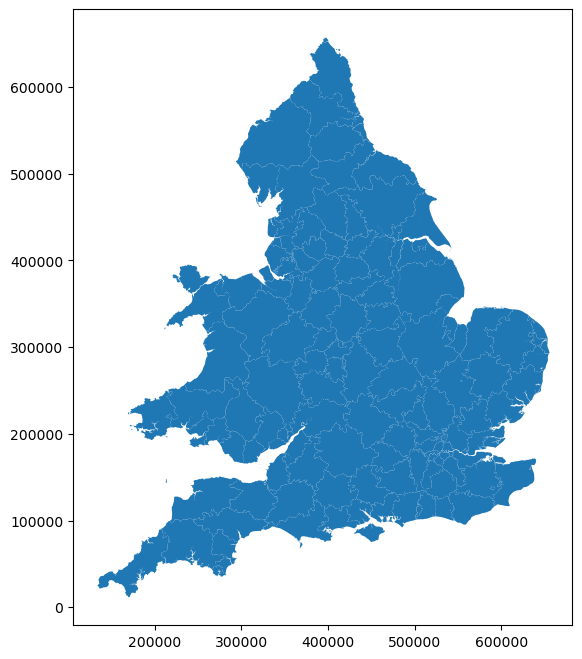

In [8]:
# Plot the shapefile
gdf_ivt_catchment.plot(figsize=(8,8));

## Map weighted average income domain score by LSOA

Join weighted average score to the IVT catchment geopandas dataframe.

In [9]:
# Join is left join on index by default, then reset index so closest IV is col
gdf_ivt_catchment = gdf_ivt_catchment.join(
    df_ivt_ids['income_domain_score_weighted_mean']).reset_index()
gdf_ivt_catchment.head()

,closest_iv,LSOA11NM,LSOA11CD,LSOA11NMW,geometry,income_domain_score_weighted_mean
0,B152TH,Birmingham 067A,E01008881,Birmingham 067A,"MULTIPOLYGON (((403011.723 266679.152, 402597....",0.182951
1,B714HJ,Birmingham 037A,E01008899,Birmingham 037A,"MULTIPOLYGON (((395950.714 272162.470, 395950....",0.202612
2,BA13NG,Bath and North East Somerset 007A,E01014370,Bath and North East Somerset 007A,"POLYGON ((354665.594 144552.500, 354665.594 14...",0.083469
3,BA214AT,East Devon 005A,E01019886,East Devon 005A,"MULTIPOLYGON (((330365.588 98427.209, 330281.9...",0.095511
4,BB23HH,Bolton 001B,E01004803,Bolton 001B,"POLYGON ((369965.000 416593.000, 370071.000 41...",0.177377


Read in hospital data, with aim of finding location of each hospital.

In [10]:
# Read in data on each hospital
gdf_units = gpd.read_file(os.path.join(paths.data, paths.hospitals))

# Combine get geometry from Easting and Northing columns
gdf_units["geometry"] = gpd.points_from_xy(
        gdf_units.Easting, gdf_units.Northing)
gdf_units = gdf_units.set_crs(epsg=27700)

# Restrict to the units delivering thrombolysis
mask = gdf_units['Use_IVT']=='1'
gdf_units = gdf_units[mask]

# Preview dataframe
gdf_units.head()

,Postcode,Hospital_name,Use_IVT,Use_MT,Use_MSU,Country,Strategic Clinical Network,Health Board / Trust,Stroke Team,SSNAP name,...,ivt_rate,Easting,Northing,long,lat,Neuroscience,30 England Thrombectomy Example,hospital_city,Notes,geometry
0,RM70AG,RM70AG,1,1,1,England,London SCN,Barking,Havering and Redbridge University Hospitals N...,Queens Hospital Romford HASU,...,11.9,551118,187780,0.179030640661934,51.5686465521504,1,0,Romford,,POINT (551118.000 187780.000)
1,E11BB,E11BB,1,1,1,England,London SCN,Barts Health NHS Trust,The Royal London Hospital,Royal London Hospital HASU,...,13.4,534829,181798,-0.0581329916047372,51.5190178361295,1,1,Royal London,,POINT (534829.000 181798.000)
2,SW66SX,SW66SX,1,1,1,England,London SCN,Imperial College Healthcare NHS Trust,"Charing Cross Hospital, London",Charing Cross Hospital HASU,...,9.9,524226,176487,-0.212736111308184,51.4737165811988,1,1,Charing Cross,,POINT (524226.000 176487.000)
3,SE59RW,SE59RW,1,1,1,England,London SCN,King's College Hospital NHS Foundation Trust,"King's College Hospital, London",King's College Hospital HASU,...,15,532536,176228,-0.0932514945350423,51.4695052907757,1,0,Kings College,,POINT (532536.000 176228.000)
4,BR68ND,BR68ND,1,0,0,England,London SCN,King's College Hospital NHS Foundation Trust,Princess Royal University Hospital,Princess Royal University Hospital HASU,...,13.3,543443,165032,0.0591464390000555,51.3662434074157,0,0,Princess Royal,,POINT (543443.000 165032.000)


When using base maps convert data to epsg:3857.

Base maps are a reference map that you can then overlay your data onto - for example, a topographic basemap showing elevation. We can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. CRS to consider:
* EPSG:27700 -- BNG (British National Grid Eastings and Northings).
* EPSG:27700 OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey. Co-ordinates are in Eastings (X) and Northings (Y).
* EPSG:4326 WGS 84 -- WGS84 - World Geodetic System 1984. Co-ordinates are in Longitude (X) and Latitude (Y).
* EPSG:3857 - projection for displaying lat/long as a flat map

In [11]:
gdf_ivt_catchment = gdf_ivt_catchment.to_crs(epsg=3857)
gdf_units = gdf_units.to_crs(epsg=3857)

Create function which can be used to add non-overlapping text labels - [see stackoverflow explanation here](https://stackoverflow.com/questions/43916834/matplotlib-dynamically-change-text-position).

In [12]:
def add_nonoverlapping_text_labels(gdf_units, ax, col, y_step=0.05, fontsize=7):
    '''
    Creates non-overlapping text labels for stroke units to the input axis
    Inputs:
    gdf_units - dataframe, contains data on each hospital
    ax - axis object, to add labels to
    col - string, label for each position
    y_step - number, amount to adjust position on y axis by
    fontsize - number, size of font in labels
    Output:
    ax - axis object with addition of text labels
    '''
    # Create empty array
    text_rectangles = []

    # Sort labels descending in y axis (gives better results)
    gdf_units['sort_by'] = gdf_units.geometry.y
    gdf_units.sort_values('sort_by', ascending=False, inplace=True)
    del gdf_units['sort_by']

    # Add labels to the plot
    # Loop through each stroke unit - in each loop, get x, y and label
    geom_unit = zip(gdf_units.geometry.x, gdf_units.geometry.y, gdf_units[col])
    for x, y, label in geom_unit:

        # Add label to the axis (xy is location of point)
        text = ax.annotate(
            text=label,
            xy=(x, y), # location of point
            xytext=(8, 8), # location of text that goes with point
            textcoords='offset points', # offset text in points from xy value
            fontsize=fontsize,
            bbox=dict(facecolor='w', alpha=0.3, edgecolor='none',
                      boxstyle="round", pad=0.1))
    
        # Adjust text position by by 2 x axis points and get axes bounding box
        x, y = text.get_position()
        new_x = x - 2
        text.set_position((new_x, y))
        rect = text.get_window_extent()

        # While text intersects with other text from rectangles of axis,
        # iterate over different y positions 10 times, checking if it prevents
        # overlap. If still intersect, just use original position
        for other_rect in text_rectangles:
            iterations = 0
            while Bbox.intersection(rect, other_rect) and iterations < 10:  # overlapping
                x, y = text.get_position()
                new_y = y - y_step
                text.set_position((x, new_y))
                rect = text.get_window_extent()
                iterations += 1
            if iterations == 10:
                # No improved location found; use original position
                text.set_position((x, y))
            text_rectangles.append(rect)

    return (ax)

Combine closest IVT with IVT catchment boundaries

In [13]:
eng_wales_bounds = pd.concat([gdf_ivt_catchment['closest_iv'], gdf_ivt_catchment.bounds], axis=1)
eng_wales_bounds = eng_wales_bounds.set_index('closest_iv')
eng_wales_bounds.head()

,minx,miny,maxx,maxy
closest_iv,,,,
B152TH,-228159.802962,6.840962e+06,-186486.338536,6.891587e+06
B714HJ,-230754.673759,6.862190e+06,-174024.968174,6.926919e+06
BA13NG,-301440.775912,6.639528e+06,-220910.832420,6.742989e+06
BA214AT,-338714.448556,6.574692e+06,-241766.759874,6.661788e+06
BB23HH,-293523.883294,7.097870e+06,-227656.460963,7.179456e+06


/home/amy/miniconda3/envs/geopandas/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_8531/3282972459.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_units.sort_values('sort_by', ascending=False, inplace=True)


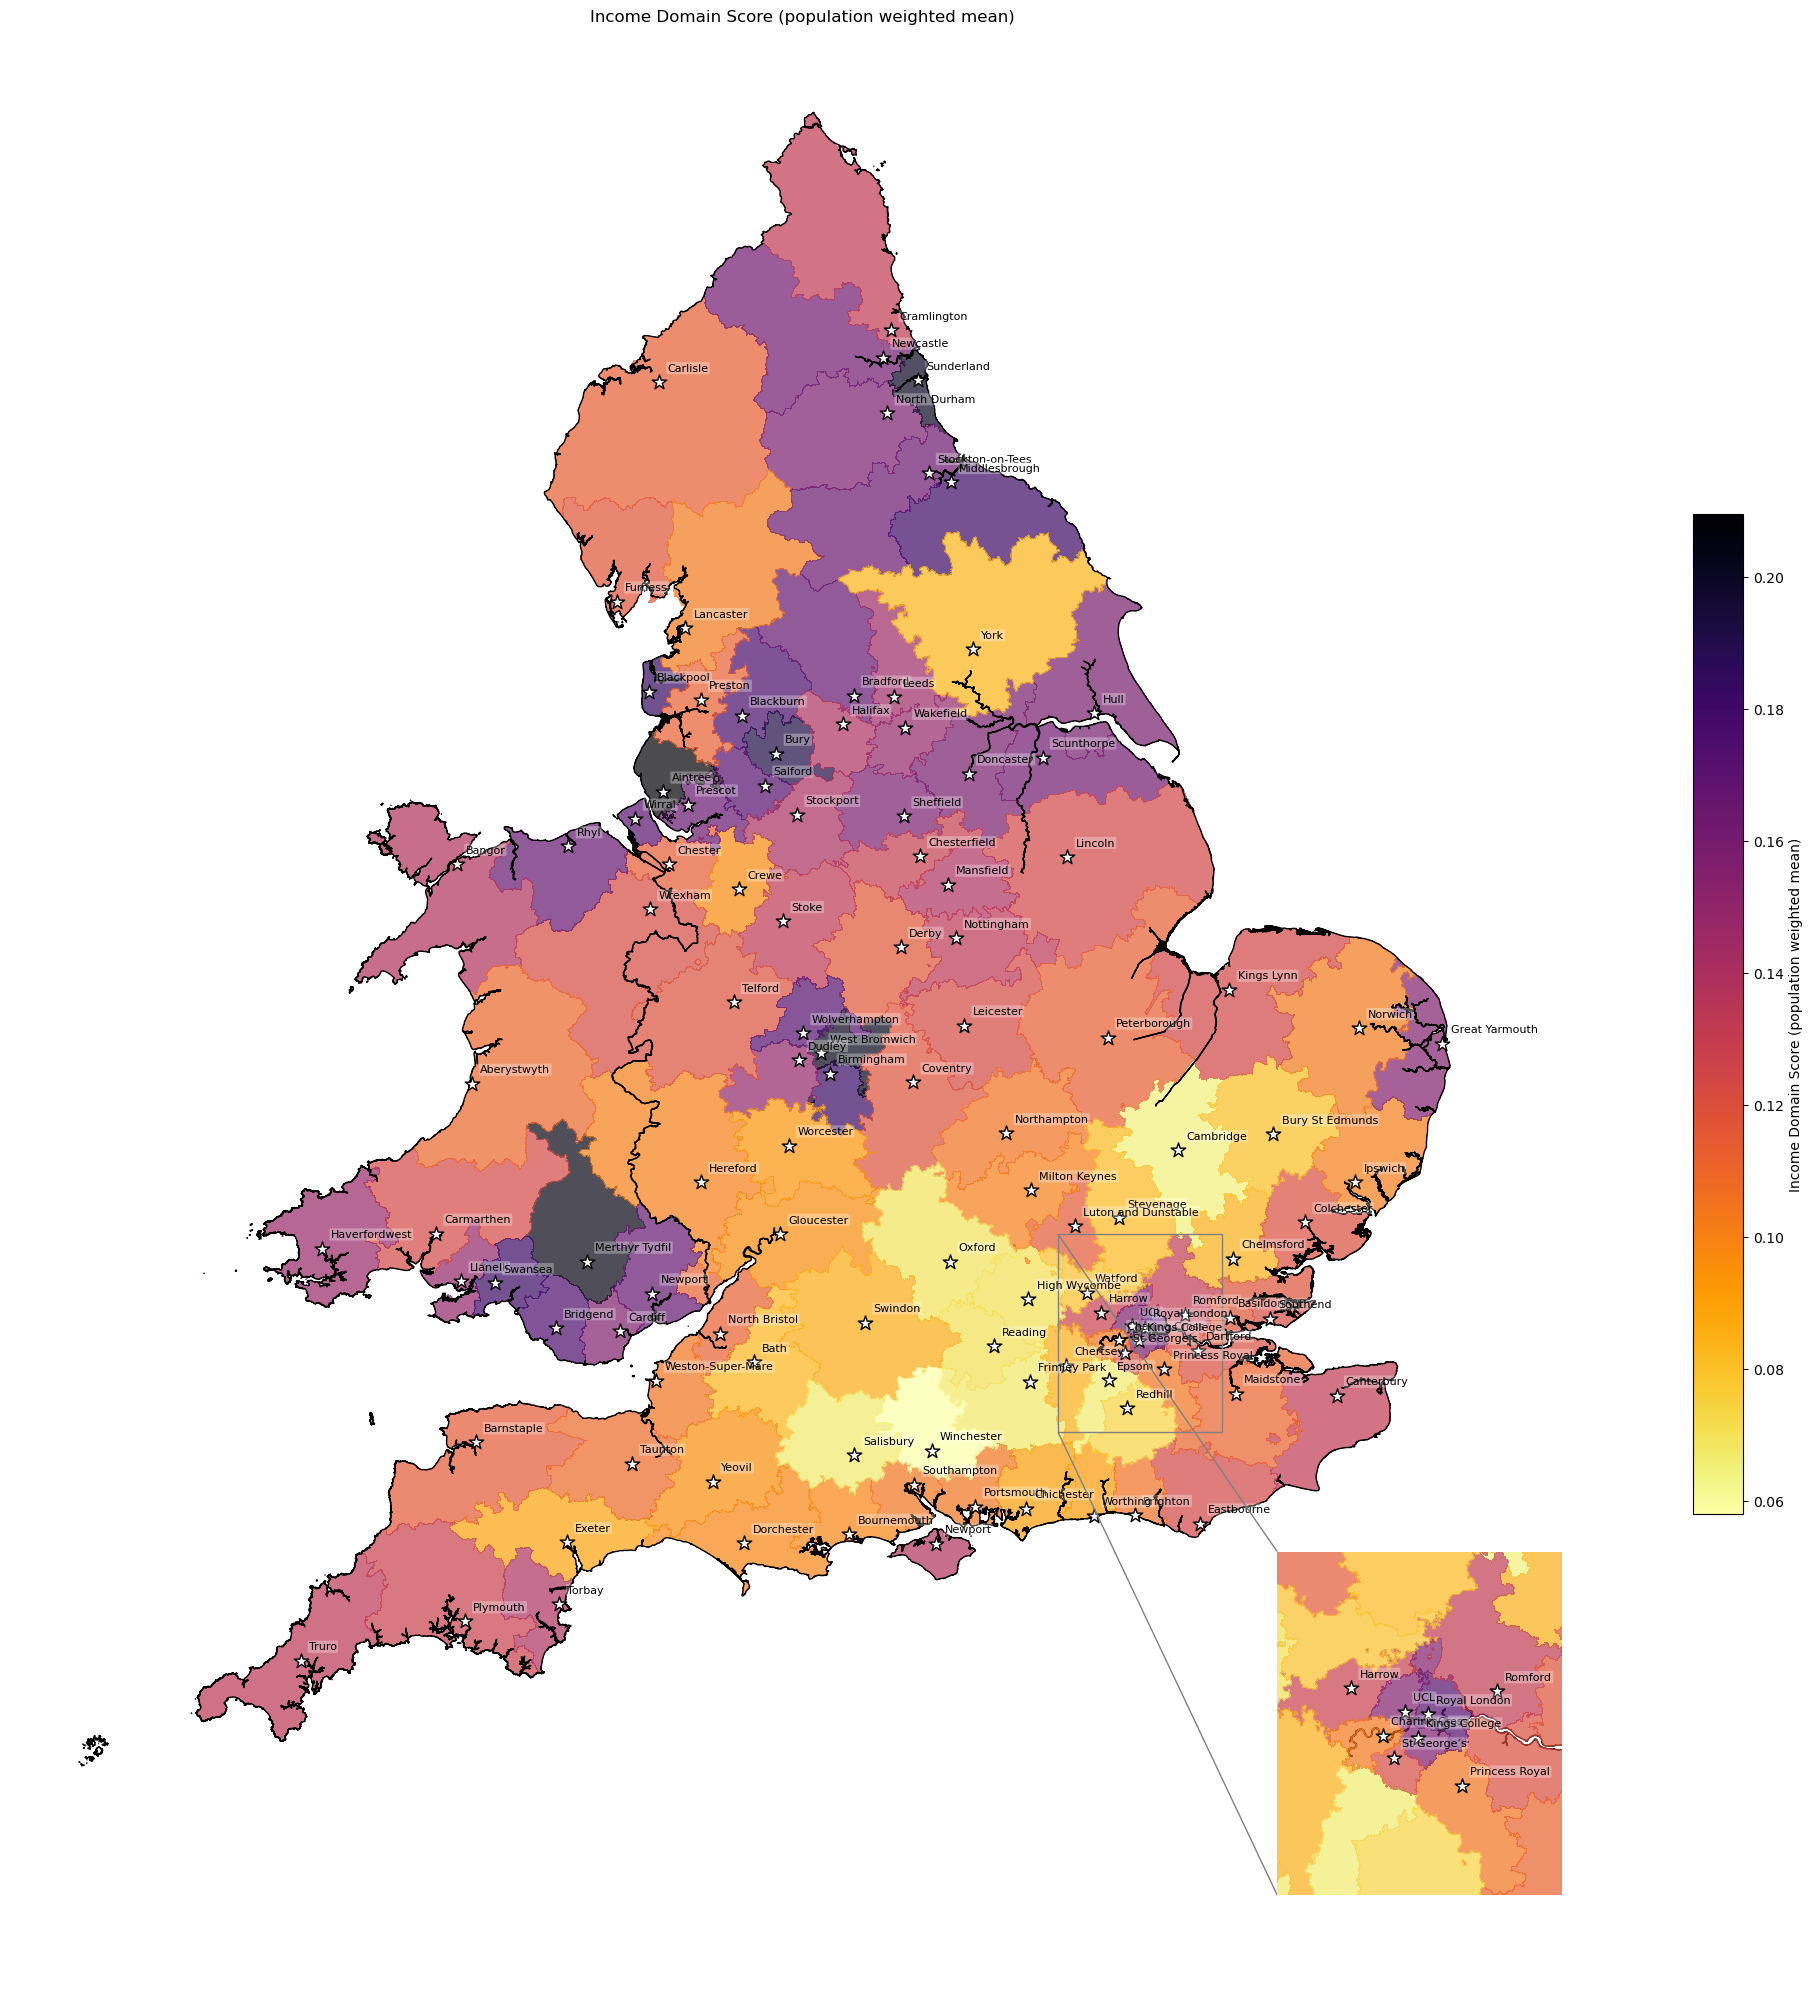

In [14]:
show_labels = True
col = 'income_domain_score_weighted_mean'
col_readable = 'Income Domain Score (population weighted mean)'

# Set up figure with max dimensions of 10x10 inch
fig, ax = plt.subplots(figsize=(20, 20))

# Plot IVT catchment areas
gdf_ivt_catchment.plot(
    ax=ax,
    column=col, # Column to apply colour
    antialiased=False, # Avoids artifact boundry lines
    edgecolor='face', # Make LSOA boundry same colour as area
    linewidth=0.0, # Use linewidth=0 to hide boarder lines
#   vmin=0, # Manual scale min (remove to make automatic)
#   vmax=70, # Manual scale max (remove to make automatic)
    cmap='inferno_r', # Colour map to use
    legend_kwds={'shrink':0.5, # Size of colourmap key
                 'label':f'{col_readable}'}, # Colourmap label
    legend=True, # Display the legend
    alpha = 0.70) # Set transparency (to reveal basemap)

# Add country border
outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)

# Add location of hospitals and labels for each hospital
gdf_units.plot(
    ax=ax, edgecolor='k', facecolor='w', markersize=120, marker='*')
if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)
        
# Make space at bottom for inset map of London
ax.set_ylim(ax.get_ylim()[0] - 100000, ax.get_ylim()[1])

# Make space on right for hospital name label
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 50000)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Create inset axis in bottom right corner
axins = ax.inset_axes([0.8, 0.05, 0.18, 0.18])

# Identify London hospitals to go in the inset map
london_mask = gdf_units["Strategic Clinical Network"]=="London SCN"
london_hospitals = gdf_units["Hospital_name"][london_mask].to_list()

# Identify map area to plot in the inset map
# initialise exteme values
minx_ = np.inf
miny_ = np.inf
maxx_ = 0
maxy_ = 0
# Find min and max x and y for the london hospitals
for h in london_hospitals:
    minx,miny,maxx,maxy =  eng_wales_bounds.loc[h]
    minx_ = min(minx_, minx)
    miny_ = min(miny_, miny)
    maxx_ = max(maxx_, maxx)
    maxy_ = max(maxy_, maxy)

# Set extent of inset map
axins.set_xlim(minx_, maxx_)
axins.set_ylim(miny_, maxy_)

# Add country boarder
outline.plot(ax=axins, edgecolor='k', facecolor='None', linewidth=1.0)

# Define lines connecting inset map to main map
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

# Plot zoom window
gdf_ivt_catchment.plot(
    ax=axins,
    column=col, # Column to apply colour
    antialiased=False, # Avoids artifact boundry lines
    edgecolor='face', # Make LSOA boundry same colour as area
    linewidth=0.0, # Use linewidth=0 to hide boarder lines
#   vmin=0, # Manual scale min (remove to make automatic)
#   vmax=70, # Manual scale max (remove to make automatic)
    cmap='inferno_r', # Colour map to use
#   legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
#   legend=True,
    alpha = 0.70) # Set transparency (to help reveal base map)


# Plot location of hospitals
london_units = gdf_units[london_mask]

london_units.plot(ax=axins, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

# Label hospitals
if show_labels:
    axins = add_nonoverlapping_text_labels(london_units, axins, 'hospital_city',
                                      y_step=0.05, fontsize=8)                                     

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map

#ctx.add_basemap(ax=axins, 
#                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)
# Remove x and y ticks

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
axins.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'outputs/map_{col}.png', dpi=300)
plt.show()

In [15]:
print(f'The range of {col_readable} across the {gdf_ivt_catchment.shape[0]} catchments is: {round(gdf_ivt_catchment[col].min(),3)} to {round(gdf_ivt_catchment[col].max(),3)}')
print(f'Median: {round(gdf_ivt_catchment[col].median(),3)}')

The range of Income Domain Score (population weighted mean) across the 113 catchments is: 0.058 to 0.209
Median: 0.122


(array([ 8.,  9., 14., 20., 21.,  9., 12., 11.,  5.,  4.]),
 array([0.05801953, 0.07316567, 0.08831181, 0.10345795, 0.11860409,
        0.13375023, 0.14889637, 0.16404251, 0.17918865, 0.19433479,
        0.20948093]),
 <BarContainer object of 10 artists>)

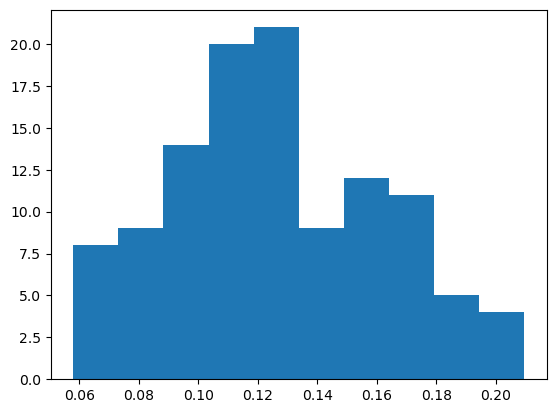

In [16]:
plt.hist(gdf_ivt_catchment[col])

Group data by "closest_ivt_unit" and calculate the weighted average of IMD (weighted by population).

https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe

In [17]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=df_lsoa.loc[x.index, 'population_all'])

# Groupby and aggregate with namedAgg [1]:
df_ivt_imd = df_lsoa.groupby(['closest_ivt_unit']).agg(
            all_persons=('population_all', 'sum'),  
            imd_2019_score_weighted_mean=('imd_2019_score', wm))
df_ivt_imd

,all_persons,imd_2019_score_weighted_mean
closest_ivt_unit,,
B152TH,963012,31.488294
B714HJ,1012389,33.655519
BA13NG,483031,13.335982
BA214AT,274432,16.858199
BB23HH,486120,31.789134
...,...,...
WD180HB,592250,12.153052
WF14DG,590899,26.646876
WR51DD,412669,16.451837


Add data about IMD, joining based on 'closest_ivt_unit'

In [18]:
gdf_ivt_catchment.set_index(['closest_iv'], inplace=True)
gdf_ivt_catchment = gdf_ivt_catchment.join(df_ivt_imd['imd_2019_score_weighted_mean']).reset_index()
gdf_ivt_catchment.head()

,closest_iv,LSOA11NM,LSOA11CD,LSOA11NMW,geometry,income_domain_score_weighted_mean,imd_2019_score_weighted_mean
0,B152TH,Birmingham 067A,E01008881,Birmingham 067A,"MULTIPOLYGON (((-217881.021 6854229.965, -2185...",0.182951,31.488294
1,B714HJ,Birmingham 037A,E01008899,Birmingham 037A,"MULTIPOLYGON (((-229414.689 6863206.747, -2294...",0.202612,33.655519
2,BA13NG,Bath and North East Somerset 007A,E01014370,Bath and North East Somerset 007A,"POLYGON ((-295019.467 6656460.038, -295019.467...",0.083469,13.335982
3,BA214AT,East Devon 005A,E01019886,East Devon 005A,"MULTIPOLYGON (((-332743.148 6582685.222, -3328...",0.095511,16.858199
4,BB23HH,Bolton 001B,E01004803,Bolton 001B,"POLYGON ((-273379.385 7103203.659, -273199.724...",0.177377,31.789134


<mark>make plot of map and hospitals a function so can use for main map and inset</mark>

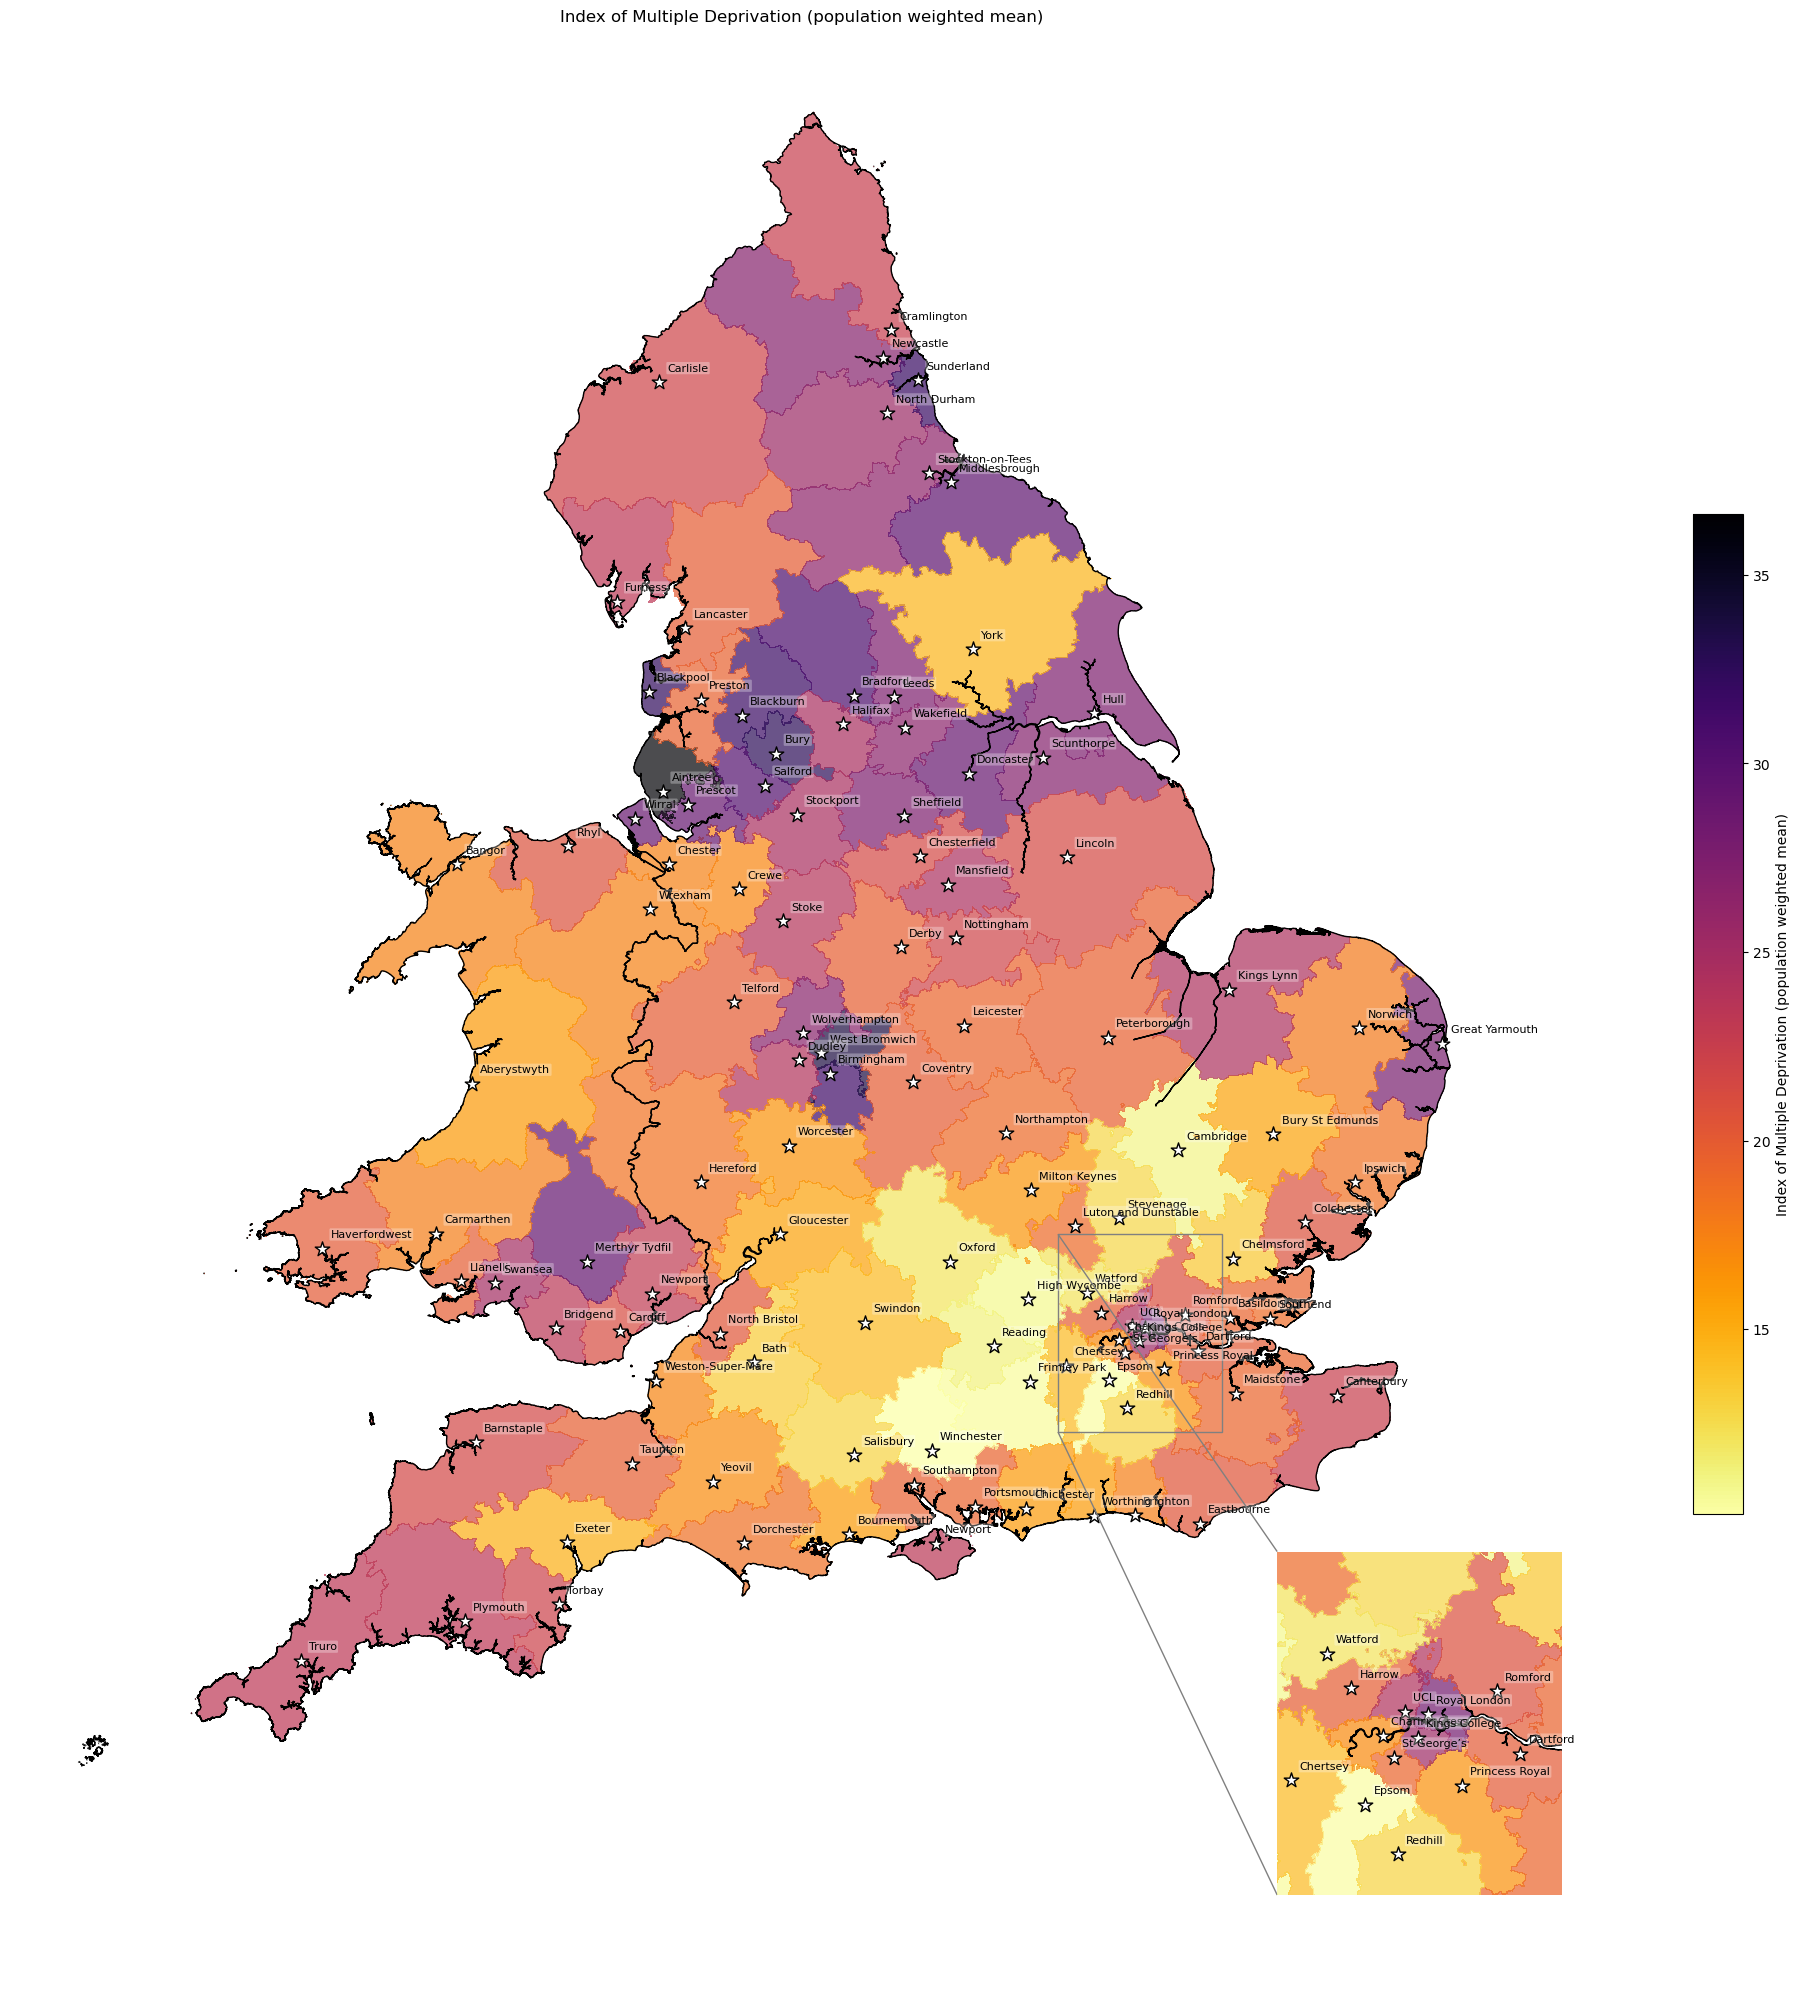

In [19]:
show_labels = True

col = 'imd_2019_score_weighted_mean'
col_readable = 'Index of Multiple Deprivation (population weighted mean)'

fig, ax = plt.subplots(figsize=(20, 20)) # Make max dimensions 10x10 inch
gdf_ivt_catchment.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Add country boarder
outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')


if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)
        
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
#ctx.add_basemap(ax, 
#                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# give some more space at bottom for london inset map
ax.set_ylim(ax.get_ylim()[0] - 100000, ax.get_ylim()[1])
# give some more space at right for hospital name label
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 50000)


# Create inset axis in bottom right corner
axins = ax.inset_axes([0.8, 0.05, 0.18, 0.18])
# Insert an inset map (loc=4 places it bottom right)
# axins = zoomed_inset_axes(ax, 2, loc=4)

# Identify london hospitals to go in the inset map
mask = gdf_units["Strategic Clinical Network"]=="London SCN"
london_hospitals = gdf_units["Hospital_name"][mask].to_list()

# identify map area to plot in the inset map
# initialise exteme values
minx_ = np.inf
miny_ = np.inf
maxx_ = 0
maxy_ = 0
# Find min and max x and y for the london hospitals
for h in london_hospitals:
    minx, miny, maxx, maxy =  eng_wales_bounds.loc[h]
    minx_ = min(minx_, minx)
    miny_ = min(miny_, miny)
    maxx_ = max(maxx_, maxx)
    maxy_ = max(maxy_, maxy)

# Set extent of inset map
axins.set_xlim(minx_, maxx_)
axins.set_ylim(miny_, maxy_)

# Define lines connecting inset map to main map
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

# Plot zoom window
gdf_ivt_catchment.plot(ax=axins, # Set which axes to use for plot (only one here)
                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap='inferno_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
#                 legend_kwds={'shrink':0.5, 'label':f'{col_readable}'},
                 # Set to display legend
#                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.70)

# Add country boarder
outline.plot(ax=axins, edgecolor='k', facecolor='None', linewidth=1.0)

# Plot location of hospitals
gdf_units.plot(ax=axins, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

# Label hospitals
if show_labels:
    axins = add_nonoverlapping_text_labels(gdf_units, axins, 'hospital_city',
                                        y_step=0.05, fontsize=8)
    
# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
#ctx.add_basemap(ax=axins, 
#                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Remove x and y ticks
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
axins.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{col_readable}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
plt.savefig(f'outputs/map_{col}.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2) # Save figure
plt.show()

In [20]:
print(f"The range of {col_readable} across the {gdf_ivt_catchment.shape[0]} catchments is: {round(gdf_ivt_catchment[col].min(),2)} to {round(gdf_ivt_catchment[col].max(),2)}")
print(f"Median: {round(gdf_ivt_catchment[col].median(),2)}")

The range of Index of Multiple Deprivation (population weighted mean) across the 113 catchments is: 10.09 to 36.6
Median: 20.03


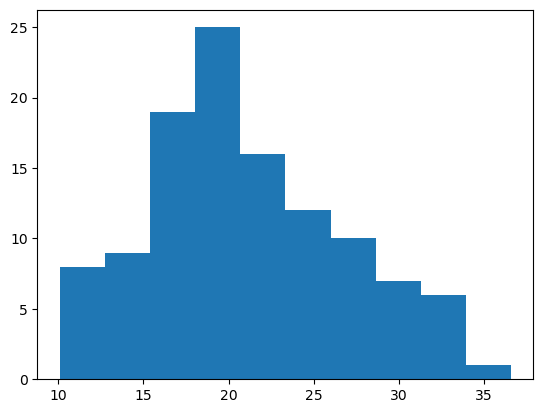

In [21]:
plt.hist(gdf_ivt_catchment[col]);